Loaded results from: results/moirai-small/ctx64/uncertainty_analysis_results.npz
Available keys: ['all_importance_scores', 'all_forecast_mae_full', 'all_forecast_rmse_full', 'all_forecast_mae_random', 'all_forecast_rmse_random', 'all_forecast_mae_most_important', 'all_forecast_rmse_most_important', 'all_forecast_errors_full', 'all_forecast_errors_random', 'all_forecast_errors_most_important', 'all_ar_cv_uncertainties', 'all_ar_iqr_uncertainties', 'all_ar_entropy_uncertainties', 'all_ar_errors', 'all_forecast_cv_full', 'all_forecast_cv_random', 'all_forecast_cv_most_important', 'all_forecast_iqr_full', 'all_forecast_entropy_full', 'per_window_importance_results', 'per_window_forecast_results', 'total_windows', 'total_samples', 'ar_uncertainty_error_correlation', 'importance_ar_uncertainty_correlation', 'forecast_uncertainty_performance_correlation']

Creating visualizations...
Results loaded from: results/moirai-small/ctx64/uncertainty_analysis_results.npz
Visualizations will be saved t

<Figure size 1600x1000 with 0 Axes>

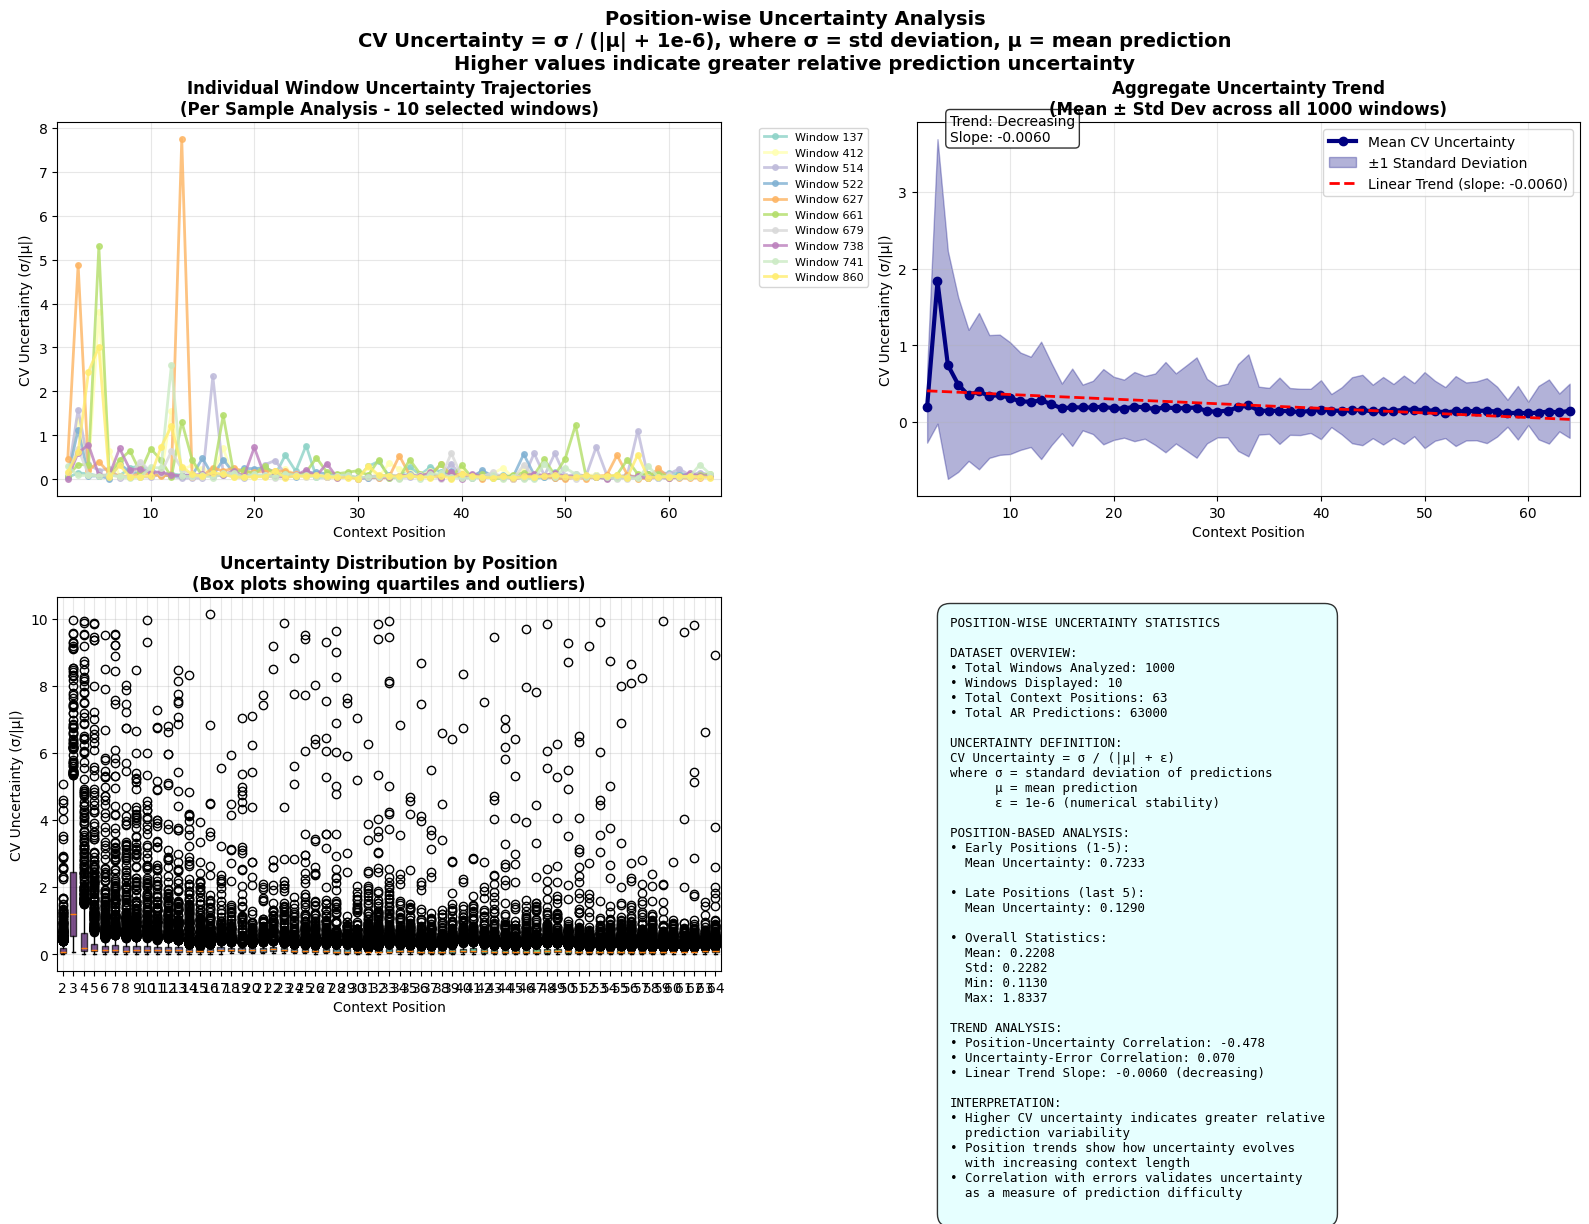


2. Creating forecasting performance comparison...
Data shapes - MAE: (1000,), CV: (8000,)
After reshaping - MAE: (1000,), CV: (1000,)
Final consistent length: 1000
Scatter plot data - MAE: 3000, Uncertainty: 3000, Methods: 3000
Forecasting performance analysis saved to: results/moirai-small/ctx64/forecasting_performance_visualization.png


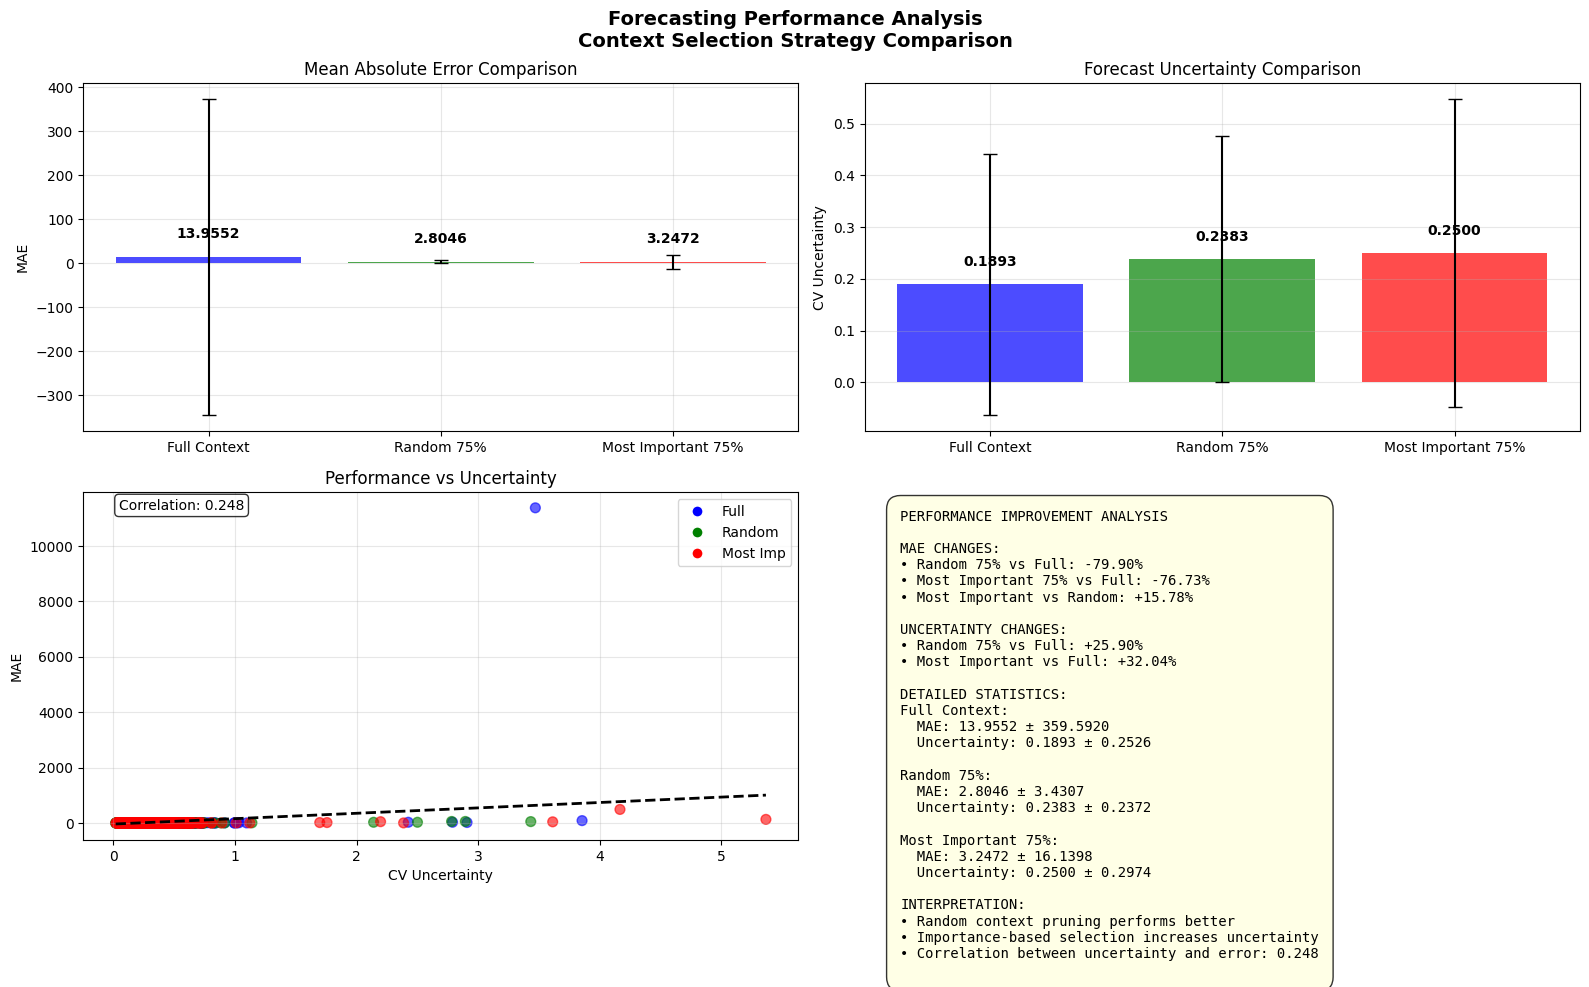


Visualization complete!
Files created:
  • position_uncertainty_visualization.png
  • forecasting_performance_visualization.png


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

def load_uncertainty_results(results_path):
    """
    Load uncertainty analysis results from npz file
    """
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results file not found: {results_path}")
    
    data = np.load(results_path, allow_pickle=True)
    print(f"Loaded results from: {results_path}")
    print(f"Available keys: {list(data.keys())}")
    
    return data

def plot_position_uncertainty_analysis(data, save_path=None):
    """
    Create position-wise uncertainty analysis plots
    """
    # Extract per-window results
    per_window_results = data['per_window_importance_results']
    
    # Set up the plot
    plt.figure(figsize=(16, 10))
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Main title with uncertainty definition
    fig.suptitle('Position-wise Uncertainty Analysis\n' + 
                'CV Uncertainty = σ / (|μ| + 1e-6), where σ = std deviation, μ = mean prediction\n' +
                'Higher values indicate greater relative prediction uncertainty',
                fontsize=14, fontweight='bold', y=0.98)
    
    # Randomly select 10 windows for per-sample visualization
    n_windows = len(per_window_results)
    n_display = min(10, n_windows)
    
    if n_windows > 10:
        np.random.seed(42)  # For reproducible selection
        selected_indices = np.random.choice(n_windows, n_display, replace=False)
        selected_results = [per_window_results[i] for i in sorted(selected_indices)]
        print(f"Displaying {n_display} randomly selected windows out of {n_windows} total windows")
    else:
        selected_results = per_window_results
        print(f"Displaying all {n_windows} windows")
    
    # Colors for selected windows
    colors = plt.cm.Set3(np.linspace(0, 1, len(selected_results)))
    
    # Find maximum context length for consistent x-axis
    max_length = max(len(result['ar_cv_uncertainties']) for result in per_window_results)
    
    # Plot 1: Individual window uncertainty trajectories (selected windows only)
    ax1 = axes[0, 0]
    
    for i, result in enumerate(selected_results):
        uncertainties = result['ar_cv_uncertainties']
        # Positions start from 2 since we skip position 0 (no context) and position 1 is first prediction
        positions = np.arange(2, len(uncertainties) + 2)
        
        ax1.plot(positions, uncertainties, 
                color=colors[i], alpha=0.8, linewidth=2,
                label=f'Window {result["window_id"]}', marker='o', markersize=4)
    
    ax1.set_title(f'Individual Window Uncertainty Trajectories\n(Per Sample Analysis - {len(selected_results)} selected windows)', 
                 fontweight='bold', fontsize=12)
    ax1.set_xlabel('Context Position')
    ax1.set_ylabel('CV Uncertainty (σ/|μ|)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, max_length + 2)
    
    # Plot 2: Aggregate uncertainty trend with confidence bands (using ALL windows)
    ax2 = axes[0, 1]
    
    # Calculate statistics for each position using ALL windows
    position_uncertainties = np.zeros(max_length)
    position_counts = np.zeros(max_length)
    position_std = np.zeros(max_length)
    
    # Collect data for each position
    position_data = [[] for _ in range(max_length)]
    
    for result in per_window_results:  # Use all windows for aggregate statistics
        uncertainties = result['ar_cv_uncertainties']
        for pos in range(len(uncertainties)):
            position_uncertainties[pos] += uncertainties[pos]
            position_counts[pos] += 1
            position_data[pos].append(uncertainties[pos])
    
    # Calculate mean and std
    mean_uncertainties = np.divide(position_uncertainties, position_counts, 
                                  out=np.zeros_like(position_uncertainties), 
                                  where=position_counts > 0)
    
    for pos in range(max_length):
        if len(position_data[pos]) > 1:
            position_std[pos] = np.std(position_data[pos])
    
    # Only plot positions with data
    valid_positions = position_counts > 0
    pos_indices = np.arange(2, max_length + 2)[valid_positions]
    mean_vals = mean_uncertainties[valid_positions]
    std_vals = position_std[valid_positions]
    
    # Plot mean line with confidence band
    ax2.plot(pos_indices, mean_vals, 'navy', linewidth=3, marker='o', 
            markersize=6, label='Mean CV Uncertainty')
    ax2.fill_between(pos_indices, mean_vals - std_vals, mean_vals + std_vals, 
                    alpha=0.3, color='navy', label='±1 Standard Deviation')
    
    # Add trend line
    if len(pos_indices) > 2:
        z = np.polyfit(pos_indices, mean_vals, 1)
        p = np.poly1d(z)
        ax2.plot(pos_indices, p(pos_indices), "r--", linewidth=2, 
                label=f'Linear Trend (slope: {z[0]:.4f})')
        
        # Add trend interpretation
        trend_direction = "Increasing" if z[0] > 0 else "Decreasing"
        ax2.text(0.05, 0.95, f'Trend: {trend_direction}\nSlope: {z[0]:.4f}', 
                transform=ax2.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.set_title(f'Aggregate Uncertainty Trend\n(Mean ± Std Dev across all {n_windows} windows)', 
                 fontweight='bold', fontsize=12)
    ax2.set_xlabel('Context Position')
    ax2.set_ylabel('CV Uncertainty (σ/|μ|)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, max_length + 2)
    
    # Plot 3: Box plots showing uncertainty distribution by position
    ax3 = axes[1, 0]
    
    # Prepare data for box plots (limit to positions with sufficient data)
    box_data = []
    box_positions = []
    
    for pos in range(max_length):
        if len(position_data[pos]) >= 3:  # At least 3 samples for meaningful box plot
            box_data.append(position_data[pos])
            box_positions.append(pos + 2)  # +2 for position offset
    
    if box_data:
        bp = ax3.boxplot(box_data, positions=box_positions, widths=0.6, 
                        patch_artist=True, showfliers=True)
        
        # Color boxes with gradient
        colors_box = plt.cm.viridis(np.linspace(0, 1, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax3.set_title('Uncertainty Distribution by Position\n(Box plots showing quartiles and outliers)', 
                 fontweight='bold', fontsize=12)
    ax3.set_xlabel('Context Position')
    ax3.set_ylabel('CV Uncertainty (σ/|μ|)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Statistics summary and correlation analysis
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate comprehensive statistics
    all_uncertainties = np.concatenate([result['ar_cv_uncertainties'] for result in per_window_results])
    all_errors = np.concatenate([result['ar_errors'] for result in per_window_results])
    
    # Position-based statistics
    early_positions = mean_uncertainties[:min(5, len(mean_uncertainties))]
    late_positions = mean_uncertainties[-min(5, len(mean_uncertainties)):]
    
    early_mean = np.nanmean(early_positions)
    late_mean = np.nanmean(late_positions)
    overall_mean = np.nanmean(mean_uncertainties[valid_positions])
    overall_std = np.nanstd(mean_uncertainties[valid_positions])
    
    # Correlation analysis
    if len(pos_indices) > 2 and len(mean_vals) > 2:
        pos_uncertainty_corr = np.corrcoef(pos_indices, mean_vals)[0, 1]
        z_trend = np.polyfit(pos_indices, mean_vals, 1)
    else:
        pos_uncertainty_corr = np.nan
        z_trend = [0]
    
    uncertainty_error_corr = np.corrcoef(all_uncertainties, all_errors)[0, 1]
    
    # Summary text
    summary_text = f"""POSITION-WISE UNCERTAINTY STATISTICS

DATASET OVERVIEW:
• Total Windows Analyzed: {len(per_window_results)}
• Windows Displayed: {len(selected_results)}
• Total Context Positions: {max_length}
• Total AR Predictions: {len(all_uncertainties)}

UNCERTAINTY DEFINITION:
CV Uncertainty = σ / (|μ| + ε)
where σ = standard deviation of predictions
      μ = mean prediction
      ε = 1e-6 (numerical stability)

POSITION-BASED ANALYSIS:
• Early Positions (1-5):
  Mean Uncertainty: {early_mean:.4f}
  
• Late Positions (last 5):
  Mean Uncertainty: {late_mean:.4f}
  
• Overall Statistics:
  Mean: {overall_mean:.4f}
  Std: {overall_std:.4f}
  Min: {np.nanmin(mean_uncertainties[valid_positions]):.4f}
  Max: {np.nanmax(mean_uncertainties[valid_positions]):.4f}

TREND ANALYSIS:
• Position-Uncertainty Correlation: {pos_uncertainty_corr:.3f}
• Uncertainty-Error Correlation: {uncertainty_error_corr:.3f}
• Linear Trend Slope: {z_trend[0]:.4f} ({"increasing" if z_trend[0] > 0 else "decreasing"})

INTERPRETATION:
• Higher CV uncertainty indicates greater relative
  prediction variability
• Position trends show how uncertainty evolves
  with increasing context length
• Correlation with errors validates uncertainty
  as a measure of prediction difficulty
    """
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=9,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=1', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Position uncertainty analysis saved to: {save_path}")
    
    plt.show()

def plot_forecasting_performance_comparison(data, save_path=None):
    """
    Create forecasting performance comparison plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Forecasting Performance Analysis\nContext Selection Strategy Comparison', 
                fontsize=14, fontweight='bold')
    
    # Extract forecasting results - handle both shapes
    mae_full = data['all_forecast_mae_full']
    mae_random = data['all_forecast_mae_random']
    mae_most_important = data['all_forecast_mae_most_important']
    
    cv_full = data['all_forecast_cv_full']
    cv_random = data['all_forecast_cv_random']
    cv_most_important = data['all_forecast_cv_most_important']
    
    print(f"Data shapes - MAE: {mae_full.shape}, CV: {cv_full.shape}")
    
    # Check if we need to handle per-window vs per-timestep data
    if len(cv_full.shape) > 1 or len(cv_full) != len(mae_full):
        # If CV data is per-timestep, take mean per window
        n_windows = len(mae_full)
        
        # Reshape CV data to match MAE data (per window)
        if len(cv_full) > n_windows:
            timesteps_per_window = len(cv_full) // n_windows
            cv_full = cv_full.reshape(n_windows, timesteps_per_window).mean(axis=1)
            cv_random = cv_random.reshape(n_windows, timesteps_per_window).mean(axis=1)
            cv_most_important = cv_most_important.reshape(n_windows, timesteps_per_window).mean(axis=1)
        
        print(f"After reshaping - MAE: {mae_full.shape}, CV: {cv_full.shape}")
    
    # Ensure all arrays have the same length
    min_length = min(len(mae_full), len(mae_random), len(mae_most_important),
                    len(cv_full), len(cv_random), len(cv_most_important))
    
    mae_full = mae_full[:min_length]
    mae_random = mae_random[:min_length]
    mae_most_important = mae_most_important[:min_length]
    cv_full = cv_full[:min_length]
    cv_random = cv_random[:min_length]
    cv_most_important = cv_most_important[:min_length]
    
    print(f"Final consistent length: {min_length}")
    
    # Plot 1: MAE comparison
    ax1 = axes[0, 0]
    methods = ['Full Context', 'Random 75%', 'Most Important 75%']
    mae_means = [np.mean(mae_full), np.mean(mae_random), np.mean(mae_most_important)]
    mae_stds = [np.std(mae_full), np.std(mae_random), np.std(mae_most_important)]
    
    bars = ax1.bar(methods, mae_means, yerr=mae_stds, capsize=5, 
                  color=['blue', 'green', 'red'], alpha=0.7)
    ax1.set_title('Mean Absolute Error Comparison')
    ax1.set_ylabel('MAE')
    ax1.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, mean_val in zip(bars, mae_means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mae_stds) * 0.1, 
                f'{mean_val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Uncertainty comparison
    ax2 = axes[0, 1]
    uncertainty_means = [np.mean(cv_full), np.mean(cv_random), np.mean(cv_most_important)]
    uncertainty_stds = [np.std(cv_full), np.std(cv_random), np.std(cv_most_important)]
    
    bars2 = ax2.bar(methods, uncertainty_means, yerr=uncertainty_stds, capsize=5, 
                   color=['blue', 'green', 'red'], alpha=0.7)
    ax2.set_title('Forecast Uncertainty Comparison')
    ax2.set_ylabel('CV Uncertainty')
    ax2.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, mean_val in zip(bars2, uncertainty_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(uncertainty_stds) * 0.1, 
                f'{mean_val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Performance vs Uncertainty scatter
    ax3 = axes[1, 0]
    
    # Combine all data with equal lengths
    all_maes = np.concatenate([mae_full, mae_random, mae_most_important])
    all_uncertainties = np.concatenate([cv_full, cv_random, cv_most_important])
    all_methods = (['Full'] * len(mae_full) + 
                  ['Random'] * len(mae_random) + 
                  ['Most Imp'] * len(mae_most_important))
    
    print(f"Scatter plot data - MAE: {len(all_maes)}, Uncertainty: {len(all_uncertainties)}, Methods: {len(all_methods)}")
    
    # Color by method
    color_map = {'Full': 'blue', 'Random': 'green', 'Most Imp': 'red'}
    colors = [color_map[method] for method in all_methods]
    
    scatter = ax3.scatter(all_uncertainties, all_maes, c=colors, alpha=0.6, s=50)
    
    # Add correlation line
    if len(all_uncertainties) > 2:
        z = np.polyfit(all_uncertainties, all_maes, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(all_uncertainties.min(), all_uncertainties.max(), 100)
        ax3.plot(x_trend, p(x_trend), "k--", linewidth=2)
        correlation = np.corrcoef(all_uncertainties, all_maes)[0, 1]
        ax3.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax3.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax3.set_title('Performance vs Uncertainty')
    ax3.set_xlabel('CV Uncertainty')
    ax3.set_ylabel('MAE')
    ax3.grid(True, alpha=0.3)
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=8, label=method)
                      for method, color in color_map.items()]
    ax3.legend(handles=legend_elements)
    
    # Plot 4: Improvement analysis
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate improvements
    random_vs_full = ((np.mean(mae_random) / np.mean(mae_full)) - 1) * 100
    most_imp_vs_full = ((np.mean(mae_most_important) / np.mean(mae_full)) - 1) * 100
    most_imp_vs_random = ((np.mean(mae_most_important) / np.mean(mae_random)) - 1) * 100
    
    # Uncertainty changes
    unc_random_vs_full = ((np.mean(cv_random) / np.mean(cv_full)) - 1) * 100
    unc_most_imp_vs_full = ((np.mean(cv_most_important) / np.mean(cv_full)) - 1) * 100
    
    improvement_text = f"""PERFORMANCE IMPROVEMENT ANALYSIS

MAE CHANGES:
• Random 75% vs Full: {random_vs_full:+.2f}%
• Most Important 75% vs Full: {most_imp_vs_full:+.2f}%
• Most Important vs Random: {most_imp_vs_random:+.2f}%

UNCERTAINTY CHANGES:
• Random 75% vs Full: {unc_random_vs_full:+.2f}%
• Most Important vs Full: {unc_most_imp_vs_full:+.2f}%

DETAILED STATISTICS:
Full Context:
  MAE: {np.mean(mae_full):.4f} ± {np.std(mae_full):.4f}
  Uncertainty: {np.mean(cv_full):.4f} ± {np.std(cv_full):.4f}

Random 75%:
  MAE: {np.mean(mae_random):.4f} ± {np.std(mae_random):.4f}
  Uncertainty: {np.mean(cv_random):.4f} ± {np.std(cv_random):.4f}

Most Important 75%:
  MAE: {np.mean(mae_most_important):.4f} ± {np.std(mae_most_important):.4f}
  Uncertainty: {np.mean(cv_most_important):.4f} ± {np.std(cv_most_important):.4f}

INTERPRETATION:
{"• Context pruning with importance improves performance" if most_imp_vs_random < 0 else "• Random context pruning performs better"}
{"• Importance-based selection reduces uncertainty" if unc_most_imp_vs_full < 0 else "• Importance-based selection increases uncertainty"}
• Correlation between uncertainty and error: {np.corrcoef(all_uncertainties, all_maes)[0, 1]:.3f}
    """
    
    ax4.text(0.05, 0.95, improvement_text, transform=ax4.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Forecasting performance analysis saved to: {save_path}")
    
    plt.show()

def main():
    """
    Main function to run the uncertainty visualization analysis
    """
    # Update this path to match your results directory structure
    # results_path = "results/moirai-large/ctx512/uncertainty_analysis_results.npz"
    results_path = "results/moirai-small/ctx64/uncertainty_analysis_results.npz"
    
    # Alternative paths you might need to check
    alternative_paths = [
        "uncertainty_analysis_results.npz",
        "results/uncertainty_analysis_results.npz",
        "moirai_uncertainty_analysis_results.npz"
    ]
    
    # Try to find the results file
    data = None
    for path in [results_path] + alternative_paths:
        if os.path.exists(path):
            try:
                data = load_uncertainty_results(path)
                results_path = path
                break
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue
    
    if data is None:
        print("Could not find or load uncertainty analysis results file.")
        print("Please check that you have run the main analysis script first.")
        print("Expected file locations:")
        for path in [results_path] + alternative_paths:
            print(f"  - {path}")
        return
    
    # Create output directory for visualizations
    output_dir = os.path.dirname(results_path) if os.path.dirname(results_path) else "."
    
    print(f"\nCreating visualizations...")
    print(f"Results loaded from: {results_path}")
    print(f"Visualizations will be saved to: {output_dir}")
    
    # Create the main position-wise uncertainty analysis
    print("\n1. Creating position-wise uncertainty analysis...")
    plot_position_uncertainty_analysis(data, 
                                      os.path.join(output_dir, 'position_uncertainty_visualization.png'))
    
    # Create forecasting performance comparison
    print("\n2. Creating forecasting performance comparison...")
    plot_forecasting_performance_comparison(data, 
                                           os.path.join(output_dir, 'forecasting_performance_visualization.png'))
    
    print(f"\nVisualization complete!")
    print(f"Files created:")
    print(f"  • position_uncertainty_visualization.png")
    print(f"  • forecasting_performance_visualization.png")

if __name__ == "__main__":
    main()